## Task 2: Applying and Expanding Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

## Load data

In [3]:
brent_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')
gdp_data = pd.read_csv('../data/GDP.csv')
unemployment_data = pd.read_csv('../data/UNRATE.csv')

In [4]:
gdp_data.head()

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [5]:
unemployment_data.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [5]:
brent_data.head()

,DATE,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [6]:
brent_data['DATE'] = pd.to_datetime(brent_data['DATE'])
brent_data.set_index('DATE', inplace=True)

C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_30508\2000120916.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_data['DATE'] = pd.to_datetime(brent_data['DATE'])


In [7]:
brent_data.head()

,Price
DATE,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


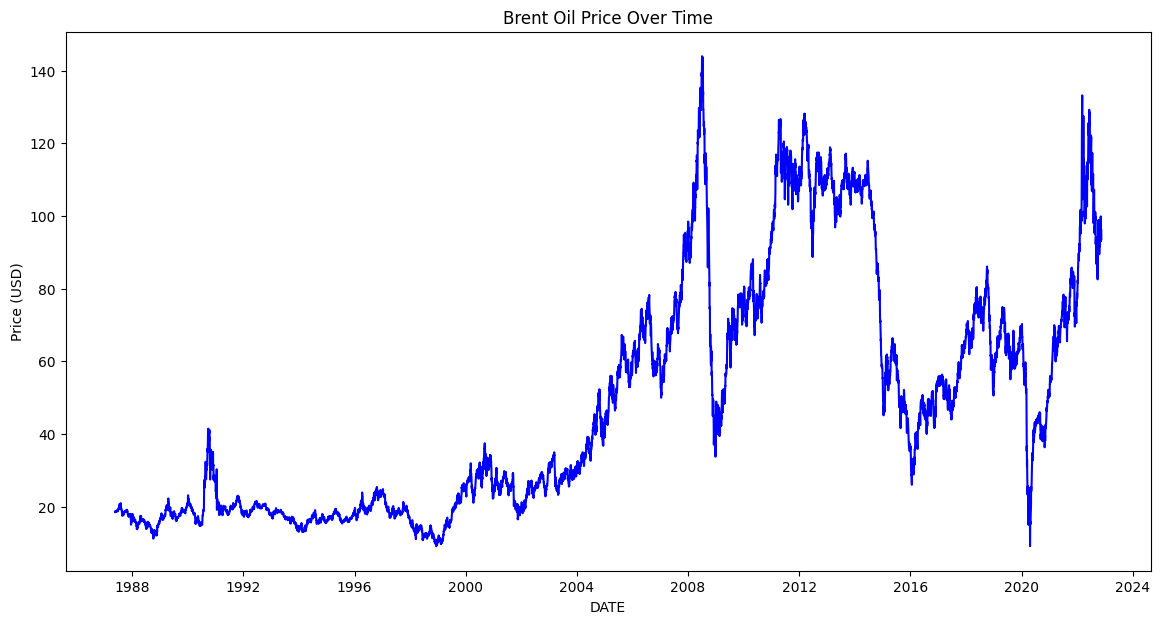

In [8]:
# Visualize the Brent Oil Price trend over time
plt.figure(figsize=(14, 7))
plt.plot(brent_data, color='blue')
plt.title('Brent Oil Price Over Time')
plt.xlabel('DATE')
plt.ylabel('Price (USD)')
plt.show()

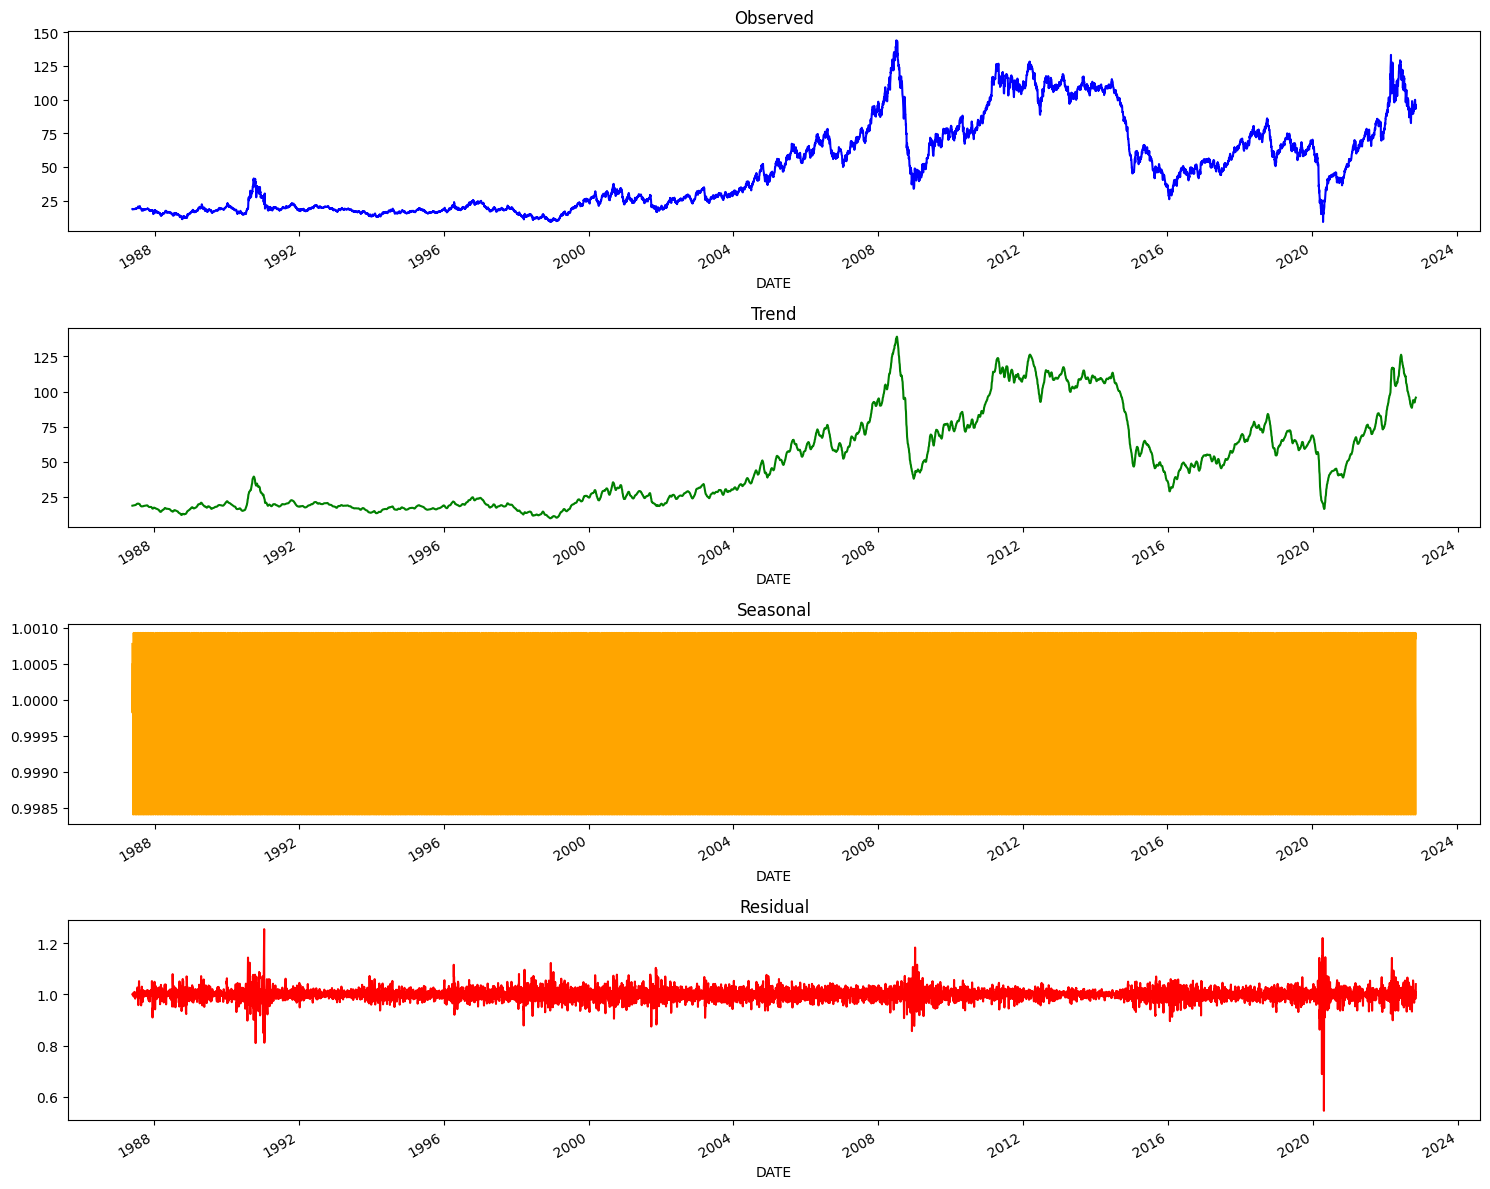

In [9]:
# Decompose the time series
decomposition = seasonal_decompose(brent_data, model='multiplicative', period=12)  # Monthly frequency assumed here

# Plot decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1, color='blue', title='Observed')
decomposition.trend.plot(ax=ax2, color='green', title='Trend')
decomposition.seasonal.plot(ax=ax3, color='orange', title='Seasonal')
decomposition.resid.plot(ax=ax4, color='red', title='Residual')
plt.tight_layout()
plt.show()


In [10]:
print(brent_data.index)
print(gdp_data.index)
print(unemployment_data.index)


DatetimeIndex(['1987-05-20', '1987-05-21', '1987-05-22', '1987-05-25',
               '1987-05-26', '1987-05-27', '1987-05-28', '1987-05-29',
               '1987-06-01', '1987-06-02',
               ...
               '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
               '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10',
               '2022-11-11', '2022-11-14'],
              dtype='datetime64[ns]', name='DATE', length=9011, freq=None)
RangeIndex(start=0, stop=311, step=1)
RangeIndex(start=0, stop=922, step=1)


In [11]:
# Reset index for brent_data to turn the DatetimeIndex into a 'Date' column
brent_data = brent_data.reset_index()

In [12]:
# Ensure 'Date' columns are in datetime format for all DataFrames
brent_data['DATE'] = pd.to_datetime(brent_data['DATE'])
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'])

In [ ]:
# Merge Brent Oil Price with GDP and Unemployment Data on 'Date' column
merged_data = brent_data.merge(gdp_data, on='DATE', how='inner') \
                         .merge(unemployment_data, on='DATE', how='inner') \
                         .dropna()

In [ ]:
# Check the result
print(merged_data.head())

        DATE  Price       GDP  UNRATE
0 1987-07-01  18.98  4884.555     6.1
1 1987-10-01  18.50  5007.994     6.0
2 1988-07-01  13.95  5282.835     5.4
3 1990-10-01  38.95  6004.733     5.9
4 1991-04-01  18.00  6126.862     6.7


## Expanding Model Scope 
## VAR(Vector Autoregression)

In [ ]:
# Check stationarity (Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] < 0.05  # Returns True if the series is stationary

# Apply differencing if non-stationary
for column in merged_data.columns:
    if not check_stationarity(merged_data[column]):
        merged_data[column] = merged_data[column].diff().dropna()

ADF Statistic: -0.29413216649489576
p-value: 0.9263312913925069
ADF Statistic: -1.7266499555418369
p-value: 0.4174365540110854
ADF Statistic: 1.5956903326194234
p-value: 0.9978445886192719
ADF Statistic: -3.5472157844101035
p-value: 0.006854133177563043


In [ ]:
# Check data types
print(merged_data.dtypes)

DATE      timedelta64[ns]
Price             float64
GDP               float64
UNRATE            float64
dtype: object


In [ ]:
# Drop the 'DATE' column as it is not needed for the VAR model
merged_data = merged_data.drop(columns=['DATE'])

In [ ]:
print(merged_data.corr())

           Price       GDP    UNRATE
Price   1.000000  0.597567 -0.221567
GDP     0.597567  1.000000 -0.353575
UNRATE -0.221567 -0.353575  1.000000


In [ ]:
# Step 2: Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_data_scaled = scaler.fit_transform(merged_data)

In [ ]:
# Step 1: Interpolate missing values in the data
jittered_data = merged_data + np.random.normal(0, 1e-6, merged_data.shape)  # Add jitter
jittered_data_interpolated = jittered_data.interpolate(method='linear', limit_direction='both')

# Check if there are still any NaN values
if jittered_data_interpolated.isna().sum().sum() > 0:
    jittered_data_interpolated = jittered_data_interpolated.fillna(method='bfill').fillna(method='ffill')

# Step 2: Apply PCA
pca = PCA(n_components=3)  # Adjust based on explained variance
data_pca = pca.fit_transform(jittered_data_interpolated)

# Step 3: Fit the VAR model on PCA-reduced data
model = VAR(data_pca)
results = model.fit(maxlags=12)

# Display results if successful
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Nov, 2024
Time:                     16:07:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    21.5940
Nobs:                     62.0000    HQIC:                   19.2809
Log likelihood:          -704.280    FPE:                9.16785e+07
AIC:                      17.7857    Det(Omega_mle):     2.25184e+07
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         78.243065        73.048362            1.071           0.284
L1.y1         -0.076739         0.161103           -0.476           0.634
L1.y2          0.257145         6.397485            0.040           0.968
L1.y3        138.

In [ ]:
# Ensure the index of merged_data is a DatetimeIndex
if not isinstance(merged_data.index, pd.DatetimeIndex):
    merged_data.index = pd.to_datetime(merged_data.index)

# Create the forecast using the results from the VAR model
forecast = results.forecast(y=results.endog[-results.k_ar:], steps=12)

# Convert forecast to DataFrame for clarity
forecast_df = pd.DataFrame(
    forecast, 
    index=pd.date_range(start=merged_data.index[-1] + pd.Timedelta(days=1), periods=12, freq='M'), 
    columns=merged_data.columns
)

print(forecast_df)


                                     Price        GDP    UNRATE
1970-01-31 00:00:00.000000073   239.638942  32.862622 -3.880459
1970-02-28 00:00:00.000000073  1035.110987  56.116311  3.494039
1970-03-31 00:00:00.000000073 -1290.815379 -90.455163 -0.673746
1970-04-30 00:00:00.000000073  1013.342490 -91.460461  2.853761
1970-05-31 00:00:00.000000073 -1638.010882  39.026567 -4.657120
1970-06-30 00:00:00.000000073  1813.336733  51.465678  2.529108
1970-07-31 00:00:00.000000073 -1653.838992 -11.566531  8.203272
1970-08-31 00:00:00.000000073  2286.402605 -32.822341  5.609264
1970-09-30 00:00:00.000000073   815.175105  15.918262 -0.793602
1970-10-31 00:00:00.000000073  1455.759884  32.223309 -7.336461
1970-11-30 00:00:00.000000073 -1905.246110  36.647618  4.175767
1970-12-31 00:00:00.000000073   504.445129 -65.497936  4.313541


C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_27160\1748422.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.date_range(start=merged_data.index[-1] + pd.Timedelta(days=1), periods=12, freq='M'),


In [ ]:
merged_data.head()

,Price,GDP,UNRATE
1970-01-01 00:00:00.000000000,NaN,NaN,6.1
1970-01-01 00:00:00.000000001,-0.48,123.439,6.0
1970-01-01 00:00:00.000000002,-4.55,274.841,5.4
1970-01-01 00:00:00.000000003,25.00,721.898,5.9
1970-01-01 00:00:00.000000004,-20.95,122.129,6.7


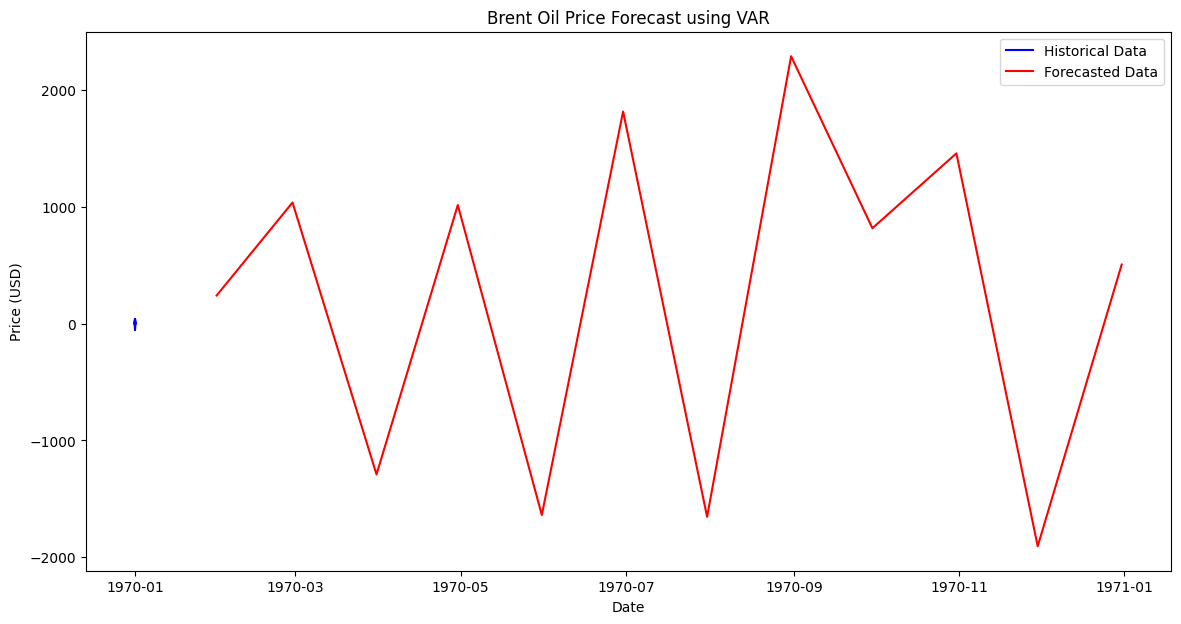

In [ ]:
# Plot historical data with forecasted values
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Price'], label='Historical Data', color='blue')
plt.plot(forecast_df['Price'], label='Forecasted Data', color='red')
plt.title('Brent Oil Price Forecast using VAR')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## Markov-Switching ARIMA Model and Hidden Markov Model

In [23]:
brent_data.head()

,DATE,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] < 0.05  # Returns True if the series is stationary

# Check for stationarity
is_stationary = check_stationarity(brent_data['Price'])

# If non-stationary, apply differencing
if not is_stationary:
    brent_data['Price_diff'] = brent_data['Price'].diff().dropna()


ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287


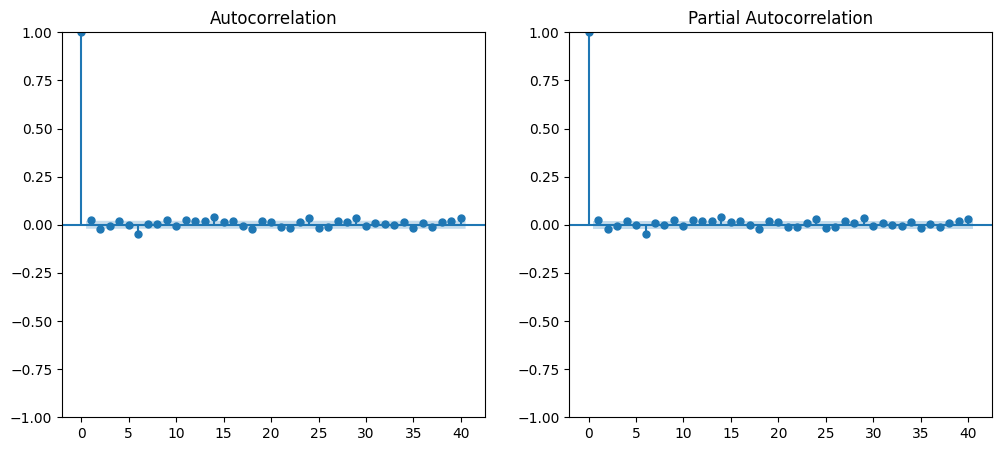

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots to help determine AR and MA terms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(brent_data['Price_diff'].dropna(), lags=40, ax=ax1)
plot_pacf(brent_data['Price_diff'].dropna(), lags=40, ax=ax2)
plt.show()


In [26]:
import statsmodels
print(statsmodels.__version__)


0.14.4


In [38]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import pandas as pd

# Prepare the data for the HMM model
price_diff = brent_data['Price'].dropna().values.reshape(-1, 1)

# Initialize the Gaussian HMM model with 2 hidden states (regimes)
n_components = 2  # Number of regimes
model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100)

# Fit the HMM model to the data
model.fit(price_diff)

# Predict the hidden states (regimes) for each observation
hidden_states = model.predict(price_diff)

# Create a DataFrame to display the original data alongside predicted hidden states
results_df = brent_data.loc[brent_data['Price'].notna()].copy()
results_df['Hidden_State'] = hidden_states

# Display the hidden states and transitions
print("Means of each hidden state:")
print(model.means_)

print("\nCovariance of each hidden state:")
print(model.covars_)

# Display the transition matrix
print("\nTransition matrix between states:")
print(model.transmat_)

# Display the first few rows of the results with hidden states
print(results_df.head())


c:\Users\NurselamHussen-ZOAEt\Downloads\New folder\10 Academy-project\Week-10\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\NurselamHussen-ZOAEt\Downloads\New folder\10 Academy-project\Week-10\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11

Means of each hidden state:
[[48.61226677]
 [48.45304929]]

Covariance of each hidden state:
[[[1084.47814676]]

 [[1081.32604018]]]

Transition matrix between states:
[[0.1524725 0.8475275]
 [0.7623189 0.2376811]]
                Price  Hidden_State
DATE                               
1987-05-31  18.580000             1
1987-06-30  18.860476             0
1987-07-31  19.856522             1
1987-08-31  18.979524             0
1987-09-30  18.313182             1


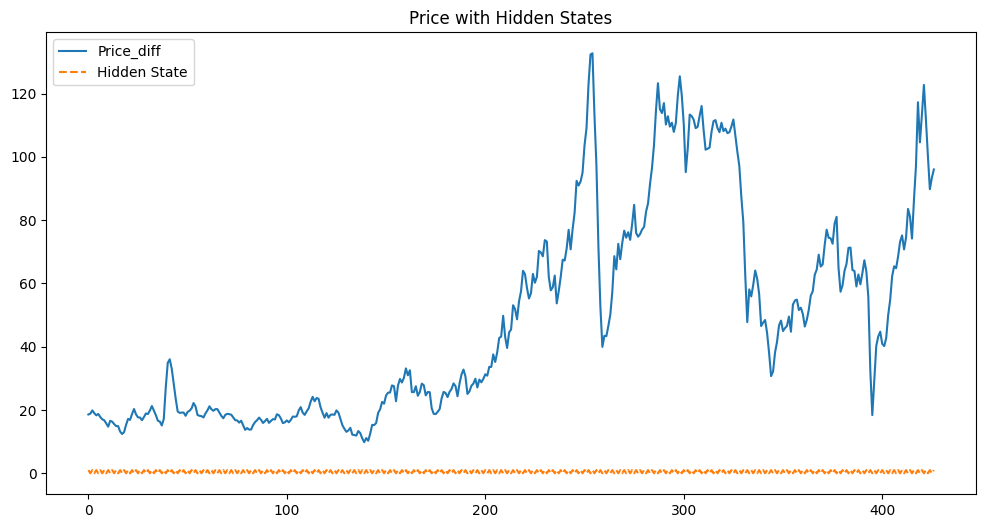

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(price_diff, label="Price_diff")
plt.plot(hidden_states, label="Hidden State", linestyle="--")
plt.legend()
plt.title("Price with Hidden States")
plt.show()

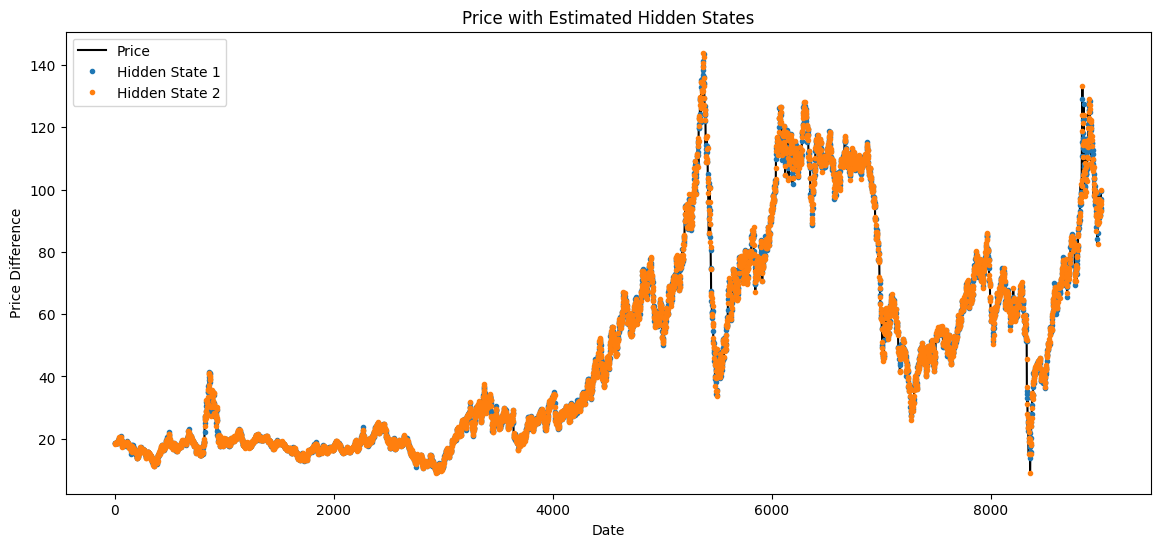

In [32]:
import matplotlib.pyplot as plt

# Plotting the original data with the estimated hidden states
plt.figure(figsize=(14, 6))
plt.plot(brent_data['Price'].dropna().index, price_diff, label='Price', color='black')
for i in range(model.n_components):
    # Highlight the areas where the model predicts each hidden state
    state = (hidden_states == i)
    plt.plot(brent_data['Price'].dropna().index[state], price_diff[state], '.', label=f"Hidden State {i+1}")
plt.title("Price with Estimated Hidden States")
plt.xlabel("Date")
plt.ylabel("Price Difference")
plt.legend()
plt.show()


In [33]:
# Log likelihood of the fitted model
log_likelihood = model.score(price_diff)
print(f"Log Likelihood: {log_likelihood:.2f}")


Log Likelihood: -44254.31


In [34]:
# Transition matrix between hidden states
print("Transition matrix between states:")
print(model.transmat_)


Transition matrix between states:
[[0.33665552 0.66334448]
 [0.61542864 0.38457136]]


In [35]:
print("Means of each hidden state (regime):")
print(model.means_)

print("\nCovariances of each hidden state (regime):")
print(model.covars_)


Means of each hidden state (regime):
[[48.50364788]
 [48.34390083]]

Covariances of each hidden state (regime):
[[[1082.58979272]]

 [[1076.94298582]]]


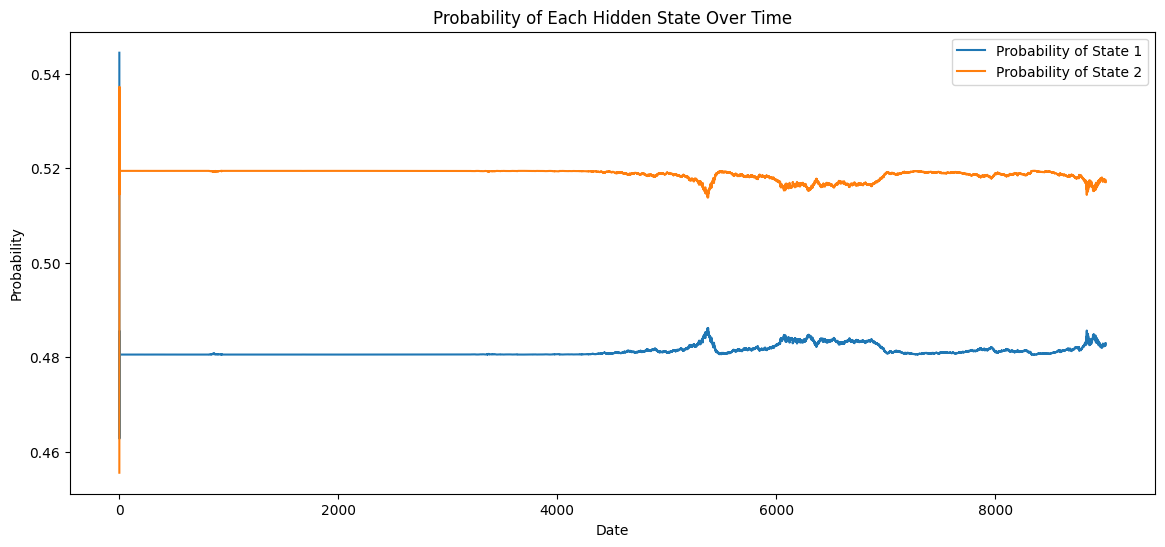

In [37]:
# Predict the probability of each state for each observation
state_probs = model.predict_proba(price_diff)

# Plot the probabilities of each hidden state
plt.figure(figsize=(14, 6))
for i in range(model.n_components):
    plt.plot(brent_data['Price'].dropna().index, state_probs[:, i], label=f"Probability of State {i+1}")
plt.title("Probability of Each Hidden State Over Time")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend()
plt.show()


In [38]:
import numpy as np

# Current state probabilities
last_obs = price_diff[-1].reshape(1, -1)  # Reshape for HMM compatibility
last_state = model.predict(last_obs)[-1]  # Predict the last known state

# Transition probabilities from the last state
next_state_probs = model.transmat_[last_state]

# Expected value of the next state
expected_next_value = np.dot(next_state_probs, model.means_.flatten())
print(f"Expected Value for the Next Observation: {expected_next_value:.2f}")


Expected Value for the Next Observation: 48.40


In [39]:
# Number of steps to forecast
n_steps = 5
forecasted_values = []

# Start from the last observed state
current_state = last_state

for _ in range(n_steps):
    # Predict the next state based on the transition probabilities
    next_state = np.random.choice(model.n_components, p=model.transmat_[current_state])
    
    # Store the expected value for this state
    forecasted_values.append(model.means_[next_state][0])
    
    # Move to the next state
    current_state = next_state

# Display the forecasted values
print("Forecasted Values for the Next Observations:")
print(forecasted_values)


Forecasted Values for the Next Observations:
[np.float64(48.34390082571881), np.float64(48.34390082571881), np.float64(48.34390082571881), np.float64(48.503647883741955), np.float64(48.34390082571881)]


C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_30508\2888284114.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=brent_data['Price'].dropna().index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='M')


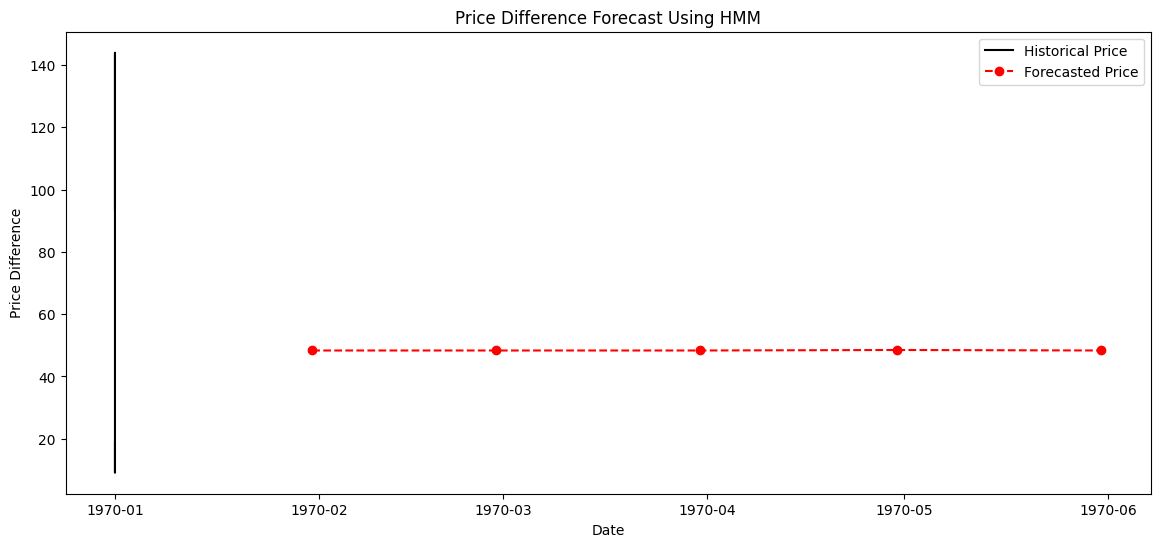

In [43]:
# Plot the original data and forecasted values
plt.figure(figsize=(14, 6))
plt.plot(brent_data['Price'].dropna().index, price_diff, label="Historical Price", color='black')

# Generate dates matching the number of forecasted values
forecast_dates = pd.date_range(start=brent_data['Price'].dropna().index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='M')

plt.plot(forecast_dates, forecasted_values, label="Forecasted Price", linestyle='--', marker='o', color='red')
plt.xlabel("Date")
plt.ylabel("Price Difference")
plt.title("Price Difference Forecast Using HMM")
plt.legend()
plt.show()


## LSTM Model for NOn-Linear Dependencies

In [14]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# # Scale data for LSTM
# scaler = MinMaxScaler(feature_range=(0, 1))
# brent_scaled = scaler.fit_transform(brent_data)

In [15]:
brent_data.head()

,DATE,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'Date' is the name of your datetime column in brent_data
if 'DATE' in brent_data.columns:
    dates = brent_data['DATE']
    # Drop the Date column and scale only the numeric columns
    brent_numeric = brent_data.drop(columns=['DATE'])
else:
    brent_numeric = brent_data  # No date column present

# Step 1: Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
brent_scaled = scaler.fit_transform(brent_numeric)

# Step 2: Optionally, convert scaled data back to DataFrame and reattach dates
brent_scaled_df = pd.DataFrame(brent_scaled, columns=brent_numeric.columns, index=brent_data.index)

if 'DATE' in brent_data.columns:
    brent_scaled_df['DATE'] = dates  # Reattach the date column if needed

# Now brent_scaled_df contains scaled numeric data along with the Date column if needed
print(brent_scaled_df.head())


      Price       DATE
0  0.070671 1987-05-20
1  0.069336 1987-05-21
2  0.070078 1987-05-22
3  0.070449 1987-05-25
4  0.070671 1987-05-26


In [17]:
# Prepare data for LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Looking back 60 time steps
X, y = create_dataset(brent_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input

In [18]:
# Split data into training and test sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = y[:train_size], y[train_size:]

In [19]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

c:\Users\NurselamHussen-ZOAEt\Downloads\New folder\10 Academy-project\Week-10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, batch_size=1, epochs=1)

7160/7160 ━━━━━━━━━━━━━━━━━━━━ 151s 21ms/step - loss: 0.0016


In [21]:
# Predict and visualize
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Inverse transform for original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


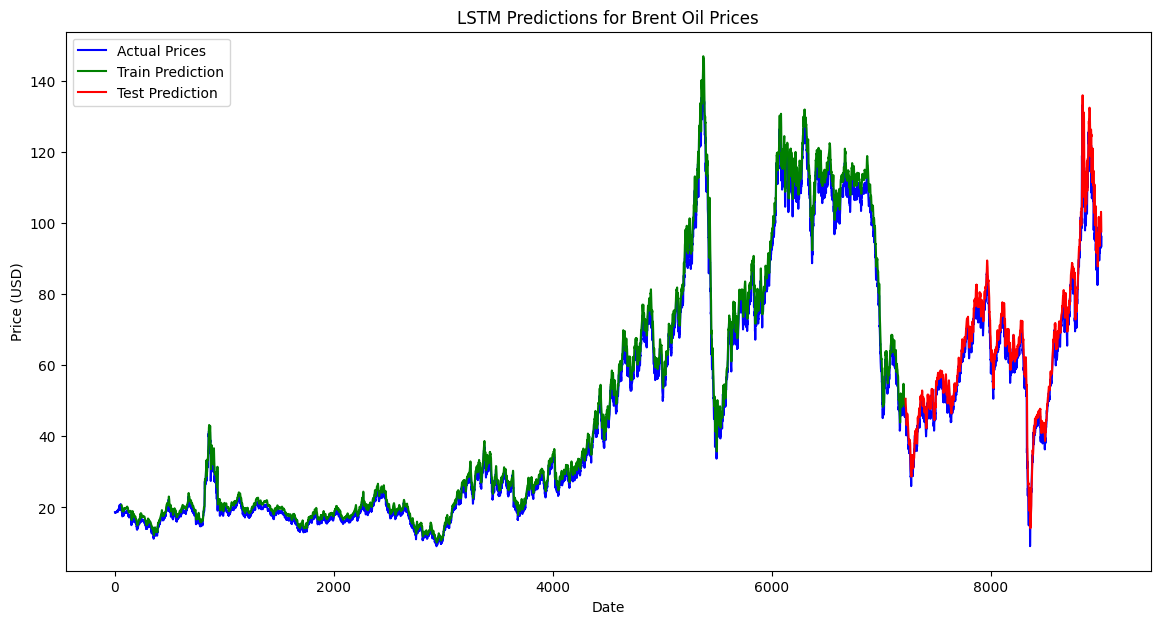

In [22]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(brent_scaled), label='Actual Prices', color='blue')
plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Train Prediction', color='green')
plt.plot(np.arange(len(brent_scaled) - len(test_predict), len(brent_scaled)), test_predict, label='Test Prediction', color='red')
plt.title('LSTM Predictions for Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Explore Other Potential Factors influencing Oil Prices

In [8]:
brent_data = pd.read_csv('../data/Copy of BrentOilPrices.csv', parse_dates=['DATE'], index_col='DATE')
gdp_data = pd.read_csv('../data/GDP.csv', parse_dates=['DATE'], index_col='DATE')
unemployment_data = pd.read_csv('../data/UNRATE.csv', parse_dates=['DATE'], index_col='DATE')

C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_28640\1182030799.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_data = pd.read_csv('../data/Copy of BrentOilPrices.csv', parse_dates=['DATE'], index_col='DATE')


In [9]:
# Inspect the first few rows of each dataset
print("Brent Oil Prices:\n", brent_data.head())
print("GDP Data:\n", gdp_data.head())
print("Unemployment Data:\n", unemployment_data.head())

Brent Oil Prices:
             Price
DATE             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63
GDP Data:
                 GDP
DATE               
1947-01-01  243.164
1947-04-01  245.968
1947-07-01  249.585
1947-10-01  259.745
1948-01-01  265.742
Unemployment Data:
             UNRATE
DATE              
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5


In [10]:
# Resample or interpolate the datasets to a monthly frequency if needed
brent_data = brent_data.resample('M').mean()
gdp_data = gdp_data.resample('M').mean()
unemployment_data = unemployment_data.resample('M').mean()

# Merge datasets on the Date index
combined_data = brent_data.join(gdp_data, how='inner', rsuffix='_GDP').join(unemployment_data, how='inner', rsuffix='_Unemployment')
combined_data.columns = ['Brent_Oil_Price', 'GDP', 'Unemployment_Rate']

# Display the combined dataset
print(combined_data.head())


            Brent_Oil_Price       GDP  Unemployment_Rate
DATE                                                    
1987-05-31        18.580000       NaN                6.3
1987-06-30        18.860476       NaN                6.2
1987-07-31        19.856522  4884.555                6.1
1987-08-31        18.979524       NaN                6.0
1987-09-30        18.313182       NaN                5.9


C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_28640\217082602.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  brent_data = brent_data.resample('M').mean()
C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_28640\217082602.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp_data = gdp_data.resample('M').mean()
C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_28640\217082602.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  unemployment_data = unemployment_data.resample('M').mean()


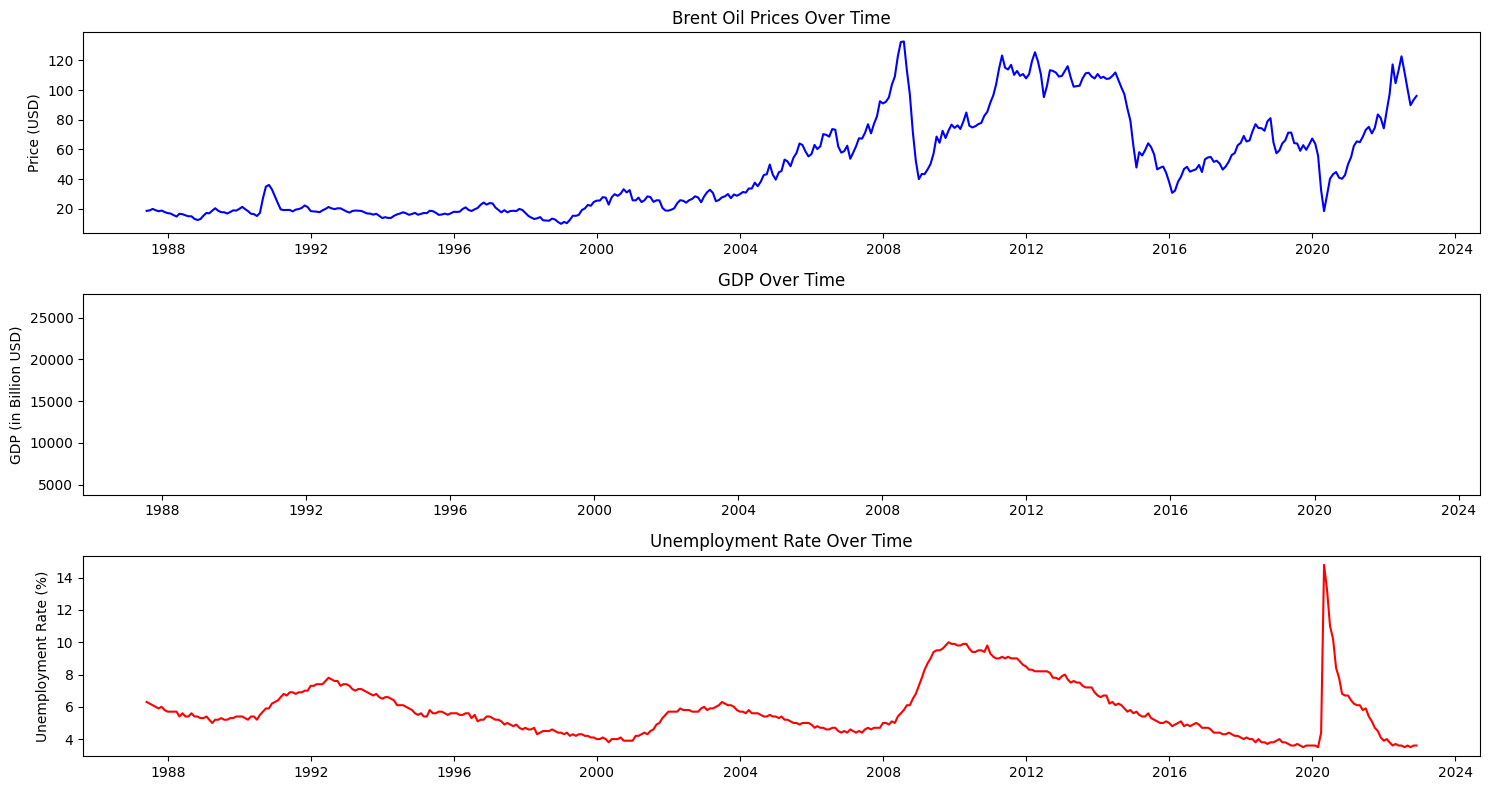

In [12]:
# Plotting Brent Oil Prices, GDP, and Unemployment Rates
plt.figure(figsize=(15, 8))

# Brent Oil Price
plt.subplot(3, 1, 1)
plt.plot(combined_data.index, combined_data['Brent_Oil_Price'], color='blue')
plt.title('Brent Oil Prices Over Time')
plt.ylabel('Price (USD)')

# GDP
plt.subplot(3, 1, 2)
plt.plot(combined_data.index, combined_data['GDP'], color='green')
plt.title('GDP Over Time')
plt.ylabel('GDP (in Billion USD)')

# Unemployment Rate
plt.subplot(3, 1, 3)
plt.plot(combined_data.index, combined_data['Unemployment_Rate'], color='red')
plt.title('Unemployment Rate Over Time')
plt.ylabel('Unemployment Rate (%)')

plt.tight_layout()
plt.show()


In [13]:
print(gdp_data.describe())


                GDP
count    311.000000
mean    7379.807868
std     7685.636801
min      243.164000
25%      812.309500
50%     4444.094000
75%    12844.971000
max    29349.924000


In [14]:
print(brent_data.index.min(), brent_data.index.max())
print(gdp_data.index.min(), gdp_data.index.max())
print(unemployment_data.index.min(), unemployment_data.index.max())


1987-05-31 00:00:00 2022-11-30 00:00:00
1947-01-31 00:00:00 2024-07-31 00:00:00
1948-01-31 00:00:00 2024-10-31 00:00:00


Text(0, 0.5, 'Normalized GDP')

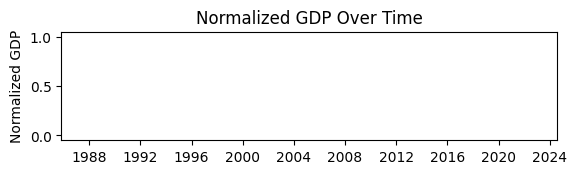

In [15]:
combined_data['GDP_normalized'] = (combined_data['GDP'] - combined_data['GDP'].min()) / (combined_data['GDP'].max() - combined_data['GDP'].min())

# Plotting the normalized GDP
plt.subplot(3, 1, 2)
plt.plot(combined_data.index, combined_data['GDP_normalized'], color='green')
plt.title('Normalized GDP Over Time')
plt.ylabel('Normalized GDP')


In [16]:
# Define the start date for filtering
start_date = '1987-05-01'

# Filter GDP and Unemployment data to match the date range of Brent Oil Prices
gdp_data_filtered = gdp_data[gdp_data.index >= start_date]
unemployment_data_filtered = unemployment_data[unemployment_data.index >= start_date]

# Display the filtered datasets
print("Filtered GDP Data:\n", gdp_data_filtered.head())
print("Filtered Unemployment Data:\n", unemployment_data_filtered.head())


Filtered GDP Data:
                  GDP
DATE                
1987-05-31       NaN
1987-06-30       NaN
1987-07-31  4884.555
1987-08-31       NaN
1987-09-30       NaN
Filtered Unemployment Data:
             UNRATE
DATE              
1987-05-31     6.3
1987-06-30     6.2
1987-07-31     6.1
1987-08-31     6.0
1987-09-30     5.9


In [17]:
# Resample to monthly frequency if necessary
brent_data = brent_data.resample('M').mean()
gdp_data_filtered = gdp_data_filtered.resample('M').mean()
unemployment_data_filtered = unemployment_data_filtered.resample('M').mean()


C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_28640\2351559248.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  brent_data = brent_data.resample('M').mean()
C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_28640\2351559248.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp_data_filtered = gdp_data_filtered.resample('M').mean()
C:\Users\NurselamHussen-ZOAEt\AppData\Local\Temp\ipykernel_28640\2351559248.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  unemployment_data_filtered = unemployment_data_filtered.resample('M').mean()


In [18]:
# Merge datasets on the Date index
combined_data = brent_data.join(gdp_data_filtered, how='inner', rsuffix='_GDP') \
                           .join(unemployment_data_filtered, how='inner', rsuffix='_Unemployment')

# Rename columns for clarity
combined_data.columns = ['Brent_Oil_Price', 'GDP', 'Unemployment_Rate']

# Display the combined dataset
print("Combined Data:\n", combined_data.head())


Combined Data:
             Brent_Oil_Price       GDP  Unemployment_Rate
DATE                                                    
1987-05-31        18.580000       NaN                6.3
1987-06-30        18.860476       NaN                6.2
1987-07-31        19.856522  4884.555                6.1
1987-08-31        18.979524       NaN                6.0
1987-09-30        18.313182       NaN                5.9


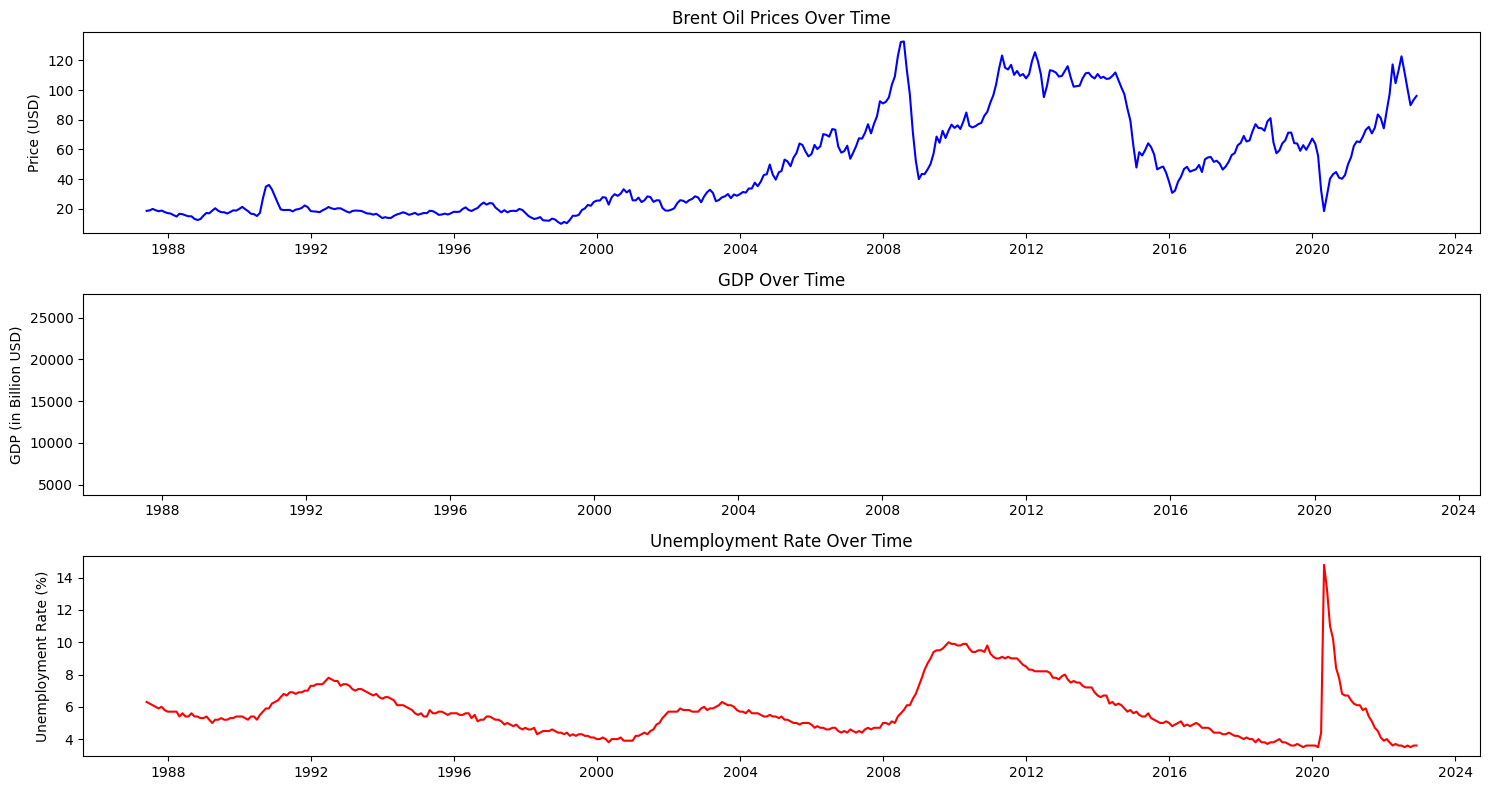

In [19]:
# Plotting Brent Oil Prices, GDP, and Unemployment Rates
plt.figure(figsize=(15, 8))

# Brent Oil Price
plt.subplot(3, 1, 1)
plt.plot(combined_data.index, combined_data['Brent_Oil_Price'], color='blue')
plt.title('Brent Oil Prices Over Time')
plt.ylabel('Price (USD)')

# GDP
plt.subplot(3, 1, 2)
plt.plot(combined_data.index, combined_data['GDP'], color='green')
plt.title('GDP Over Time')
plt.ylabel('GDP (in Billion USD)')

# Unemployment Rate
plt.subplot(3, 1, 3)
plt.plot(combined_data.index, combined_data['Unemployment_Rate'], color='red')
plt.title('Unemployment Rate Over Time')
plt.ylabel('Unemployment Rate (%)')

plt.tight_layout()
plt.show()


In [20]:
# Check the date range and values of the GDP data
print("GDP Data Date Range:", gdp_data_filtered.index.min(), gdp_data_filtered.index.max())
print("GDP Data Values:\n", gdp_data_filtered.describe())


GDP Data Date Range: 1987-05-31 00:00:00 2024-07-31 00:00:00
GDP Data Values:
                 GDP
count    149.000000
mean   13850.902369
std     6401.383508
min     4884.555000
25%     8259.771000
50%    13599.160000
75%    18279.784000
max    29349.924000


In [21]:
print("Filtered GDP Data:\n", gdp_data_filtered)


Filtered GDP Data:
                   GDP
DATE                 
1987-05-31        NaN
1987-06-30        NaN
1987-07-31   4884.555
1987-08-31        NaN
1987-09-30        NaN
...               ...
2024-03-31        NaN
2024-04-30  29016.714
2024-05-31        NaN
2024-06-30        NaN
2024-07-31  29349.924

[447 rows x 1 columns]


In [22]:
print("Number of NaN values in GDP Data:", gdp_data_filtered.isna().sum())


Number of NaN values in GDP Data: GDP    298
dtype: int64


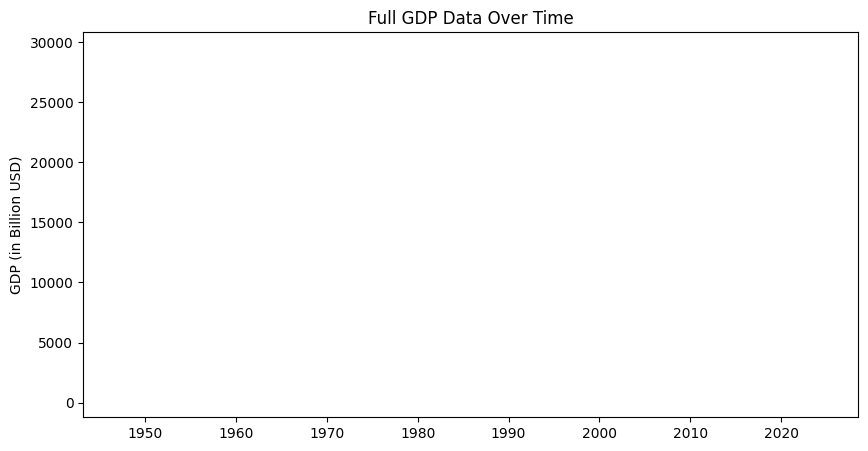

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(gdp_data.index, gdp_data['GDP'], color='green')
plt.title('Full GDP Data Over Time')
plt.ylabel('GDP (in Billion USD)')
plt.show()


In [24]:
# Find dates with NaN values in GDP data
nan_dates = gdp_data_filtered[gdp_data_filtered.isna().any(axis=1)]
print("Dates with NaN GDP Values:\n", nan_dates)


Dates with NaN GDP Values:
             GDP
DATE           
1987-05-31  NaN
1987-06-30  NaN
1987-08-31  NaN
1987-09-30  NaN
1987-11-30  NaN
...         ...
2023-12-31  NaN
2024-02-29  NaN
2024-03-31  NaN
2024-05-31  NaN
2024-06-30  NaN

[298 rows x 1 columns]


In [25]:
# Interpolate to fill NaN values
gdp_data_filtered['GDP'] = gdp_data_filtered['GDP'].interpolate()

# Check again for NaN values
print("Number of NaN values in GDP Data after interpolation:", gdp_data_filtered.isna().sum())


Number of NaN values in GDP Data after interpolation: GDP    2
dtype: int64


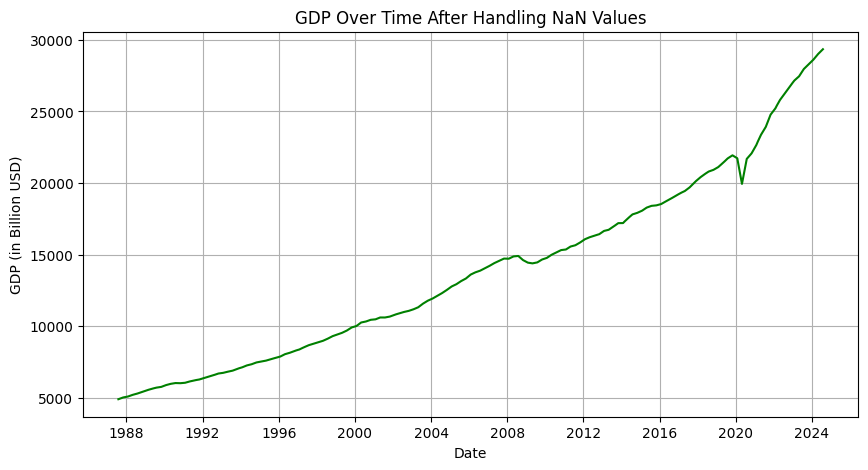

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(gdp_data_filtered.index, gdp_data_filtered['GDP'], color='green')
plt.title('GDP Over Time After Handling NaN Values')
plt.ylabel('GDP (in Billion USD)')
plt.xlabel('Date')
plt.grid()
plt.show()


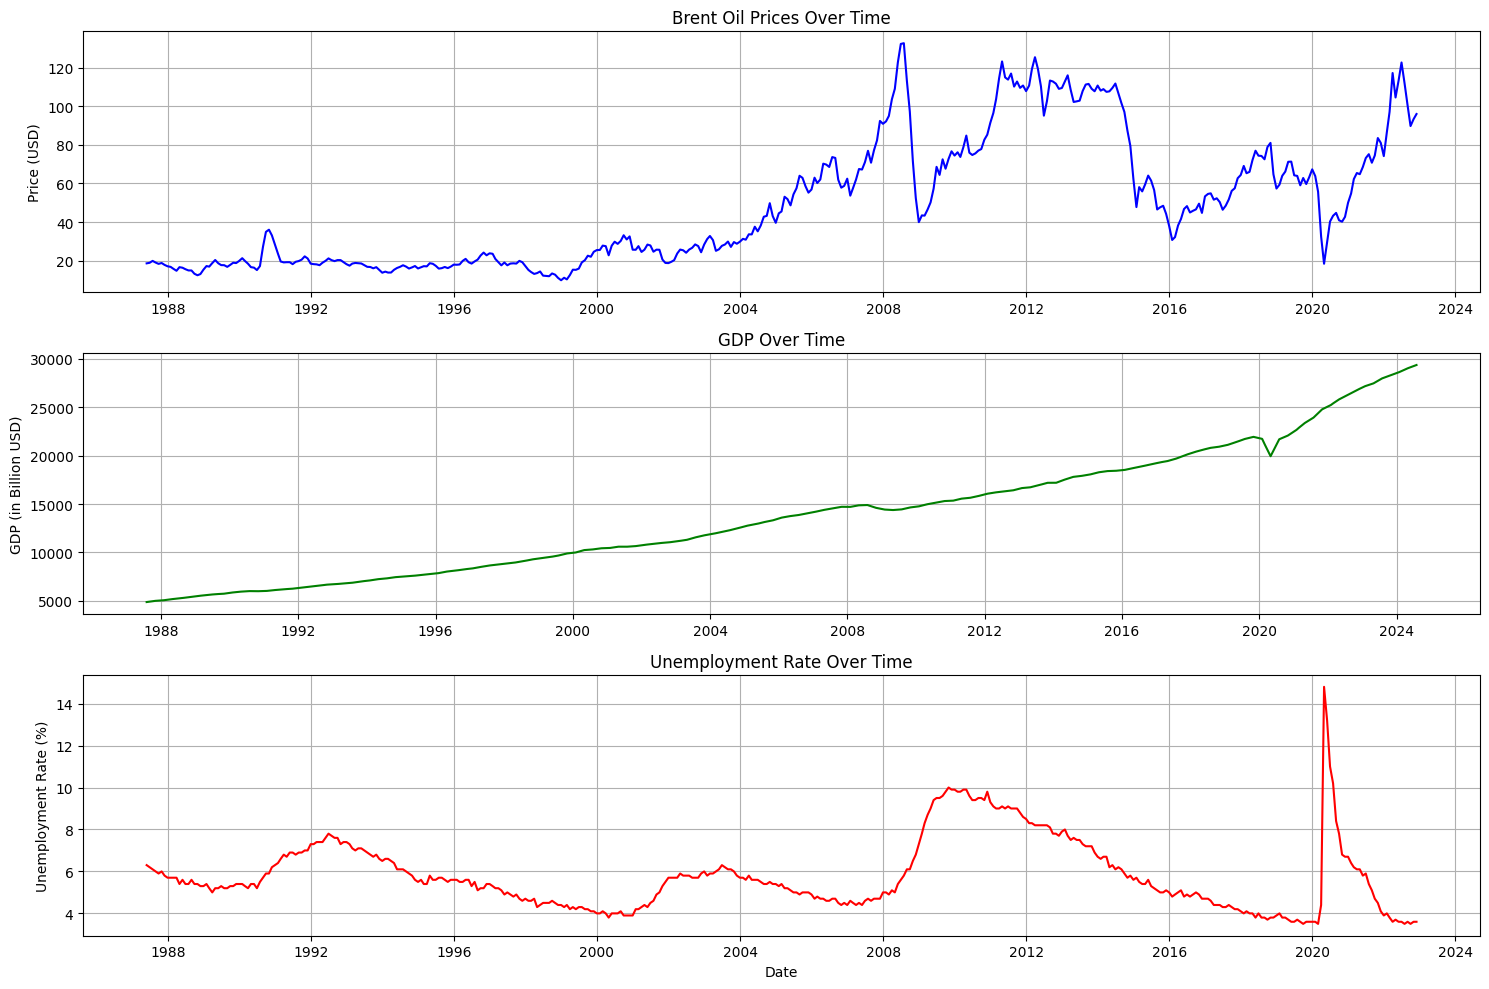

In [28]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
plt.figure(figsize=(15, 10))

# Plotting Brent Oil Prices
plt.subplot(3, 1, 1)
plt.plot(combined_data.index, combined_data['Brent_Oil_Price'], color='blue')
plt.title('Brent Oil Prices Over Time')
plt.ylabel('Price (USD)')
plt.grid()

# Plotting GDP
plt.subplot(3, 1, 2)
plt.plot(gdp_data_filtered.index, gdp_data_filtered['GDP'], color='green')
plt.title('GDP Over Time')
plt.ylabel('GDP (in Billion USD)')
plt.grid()

# Plotting Unemployment Rate
plt.subplot(3, 1, 3)
plt.plot(combined_data.index, combined_data['Unemployment_Rate'], color='red')
plt.title('Unemployment Rate Over Time')
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Date')
plt.grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Correlation Matrix:
                    Brent_Oil_Price       GDP  Unemployment_Rate
Brent_Oil_Price           1.000000  0.707172           0.211205
GDP                       0.707172  1.000000          -0.053622
Unemployment_Rate         0.211205 -0.053622           1.000000


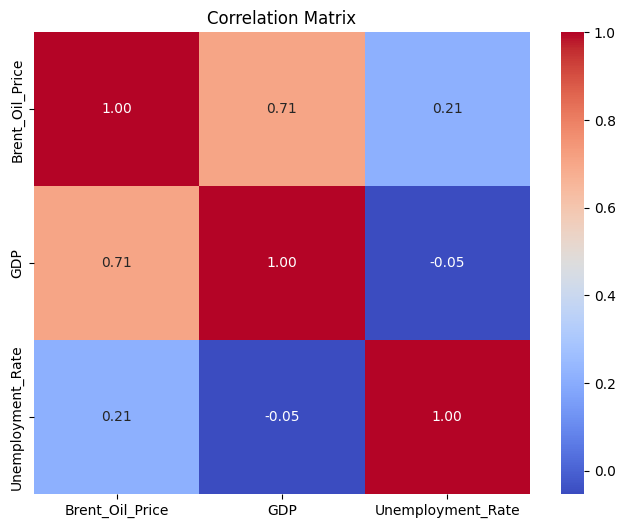

In [31]:
# Calculate the correlation matrix
correlation_matrix = combined_data[['Brent_Oil_Price', 'GDP', 'Unemployment_Rate']].corr()

# Display the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Visualize the correlation matrix using a heatmap
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [33]:
# Check for missing values in the combined data
missing_values = combined_data[['Brent_Oil_Price', 'GDP', 'Unemployment_Rate']].isna().sum()
print("Missing values in each column:\n", missing_values)

# Drop rows with any missing values in the relevant columns
cleaned_data = combined_data.dropna(subset=['Brent_Oil_Price', 'GDP', 'Unemployment_Rate'])

# Check the shape of the cleaned data
print("Shape of cleaned data:", cleaned_data.shape)

# Prepare the data for regression
X = cleaned_data[['GDP', 'Unemployment_Rate']]  # Independent variables
y = cleaned_data['Brent_Oil_Price']  # Dependent variable

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the regression results
print(model.summary())


Missing values in each column:
 Brent_Oil_Price        0
GDP                  285
Unemployment_Rate      0
dtype: int64
Shape of cleaned data: (142, 3)
                            OLS Regression Results                            
Dep. Variable:        Brent_Oil_Price   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     85.54
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           6.04e-25
Time:                        12:42:16   Log-Likelihood:                -640.91
No. Observations:                 142   AIC:                             1288.
Df Residuals:                     139   BIC:                             1297.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>

Variance Inflation Factors:
              Feature       VIF
0                GDP  4.247841
1  Unemployment_Rate  4.247841


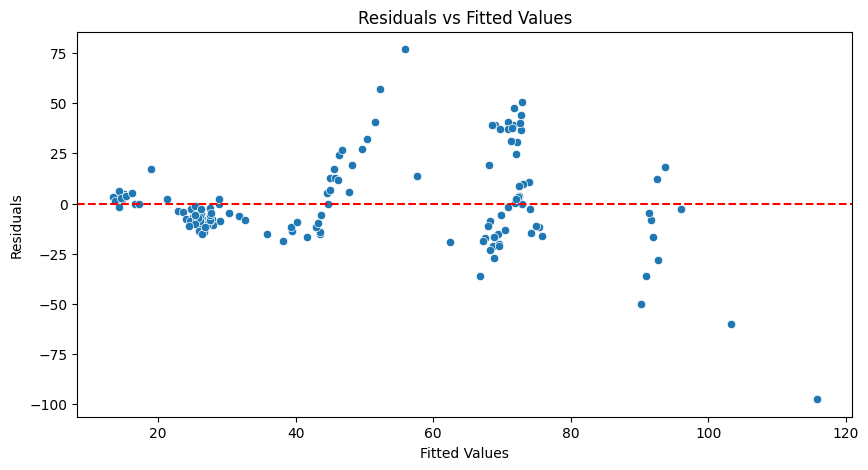

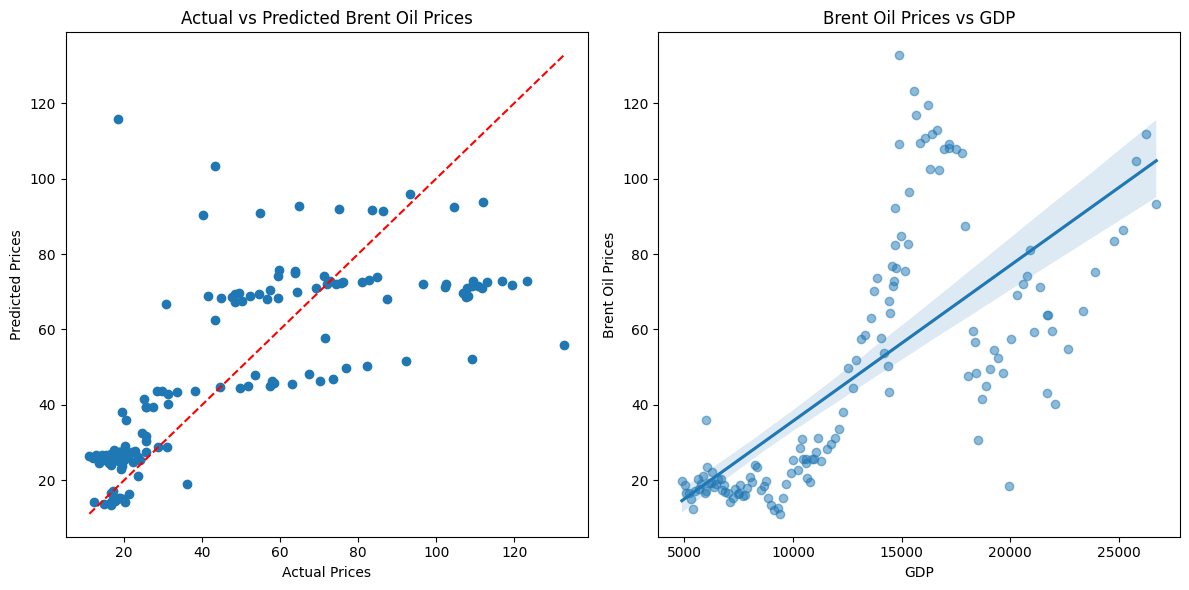

In [35]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Check for Multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = cleaned_data[['GDP', 'Unemployment_Rate']]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factors:\n", vif_data)

# 2. Plot Residuals
residuals = model.resid
plt.figure(figsize=(10, 5))
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 3. Visualize the Regression Results
plt.figure(figsize=(12, 6))

# Plotting actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(cleaned_data['Brent_Oil_Price'], model.fittedvalues)
plt.plot([cleaned_data['Brent_Oil_Price'].min(), cleaned_data['Brent_Oil_Price'].max()],
         [cleaned_data['Brent_Oil_Price'].min(), cleaned_data['Brent_Oil_Price'].max()],
         color='red', linestyle='--')
plt.title('Actual vs Predicted Brent Oil Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Plotting the relationship with GDP
plt.subplot(1, 2, 2)
sns.regplot(x='GDP', y='Brent_Oil_Price', data=cleaned_data, scatter_kws={'alpha':0.5})
plt.title('Brent Oil Prices vs GDP')
plt.xlabel('GDP')
plt.ylabel('Brent Oil Prices')

plt.tight_layout()
plt.show()
